In [68]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
from zipfile import ZipFile
import seaborn as sn
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.models import Sequential
from keras.applications import ResNet50
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [20]:
dataset = []
labels = []

In [21]:
def prepare_Images(label,path):
    img=cv2.imread(path,cv2.IMREAD_COLOR)
    img_res=cv2.resize(img,(224,224))
    img_array = img_to_array(img_res)
    img_array = img_array/255
    dataset.append(img_array)
    labels.append(str(label))

In [22]:
train_Data = pd.read_csv("data/train.csv")
train_Data.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [23]:
id_code_Data = train_Data['id_code']
diagnosis_Data = train_Data['diagnosis']

In [24]:
for id_code,diagnosis in tqdm(zip(id_code_Data,diagnosis_Data)):
    path = os.path.join('data/train_images','{}.png'.format(id_code))
    prepare_Images(diagnosis,path)

3662it [03:47, 16.10it/s]


In [25]:
#Convert list to numpy array
images = np.array(dataset)
label_arr = np.array(labels)

In [26]:
#spliting the training data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(images,label_arr,test_size=0.20,random_state=42)

In [27]:
#Convert to class labels categorical
y_train = np_utils.to_categorical(y_train, num_classes=5)
y_test = np_utils.to_categorical(y_test, num_classes=5)

In [124]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('sigmoid'))

model.compile(loss='mse',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [125]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
activation_50 (Activation)   (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_51 (Activation)   (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 54, 54, 32)      

In [126]:
Callbacks=[ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=8, verbose=True)]

In [127]:
history = model.fit(x_train,y_train,batch_size=32,epochs=10,verbose=1,callbacks=Callbacks,validation_data=(x_test, y_test))

Train on 2929 samples, validate on 733 samples
Epoch 1/10
2929/2929 [==============================] - 23s 8ms/step - loss: 0.1370 - accuracy: 0.5886 - val_loss: 0.0875 - val_accuracy: 0.6958
Epoch 2/10
2929/2929 [==============================] - 8s 3ms/step - loss: 0.0866 - accuracy: 0.7078 - val_loss: 0.0896 - val_accuracy: 0.7121
Epoch 3/10
2929/2929 [==============================] - 8s 3ms/step - loss: 0.0829 - accuracy: 0.7146 - val_loss: 0.0862 - val_accuracy: 0.7190
Epoch 4/10
2929/2929 [==============================] - 8s 3ms/step - loss: 0.0802 - accuracy: 0.7159 - val_loss: 0.0758 - val_accuracy: 0.7394
Epoch 5/10
2929/2929 [==============================] - 8s 3ms/step - loss: 0.0783 - accuracy: 0.7207 - val_loss: 0.0830 - val_accuracy: 0.7012
Epoch 6/10
2929/2929 [==============================] - 8s 3ms/step - loss: 0.0774 - accuracy: 0.7293 - val_loss: 0.0743 - val_accuracy: 0.7422
Epoch 7/10
2929/2929 [==============================] - 8s 3ms/step - loss: 0.0752 - acc

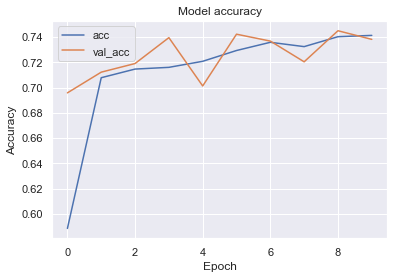

In [128]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.show()

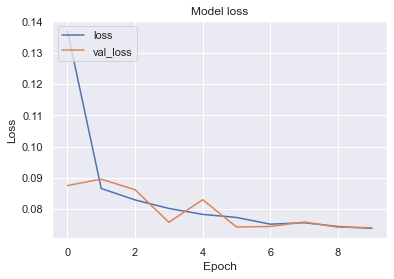

In [129]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [130]:
pred = model.predict(x_test)

In [131]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score
score = round(accuracy_score(y_test.argmax(axis=1), pred.argmax(axis=1)),2)
print(score)

0.74


In [132]:
k_score = round(cohen_kappa_score(y_test.argmax(axis=1), pred.argmax(axis=1)),2)
print(k_score)

0.59


In [133]:
report = classification_report(y_test.argmax(axis=1), pred.argmax(axis=1))
print(report)

precision    recall  f1-score   support

           0       0.91      0.96      0.93       351
           1       0.40      0.37      0.38        68
           2       0.59      0.83      0.69       213
           3       0.67      0.06      0.10        36
           4       1.00      0.02      0.03        65

    accuracy                           0.74       733
   macro avg       0.71      0.44      0.43       733
weighted avg       0.77      0.74      0.69       733



In [134]:
cm = confusion_matrix(y_test.argmax(axis=1),pred.argmax(axis=1))
print(cm)

[[337   4  10   0   0]
 [  7  25  35   1   0]
 [ 15  22 176   0   0]
 [  2   5  27   2   0]
 [ 10   6  48   0   1]]


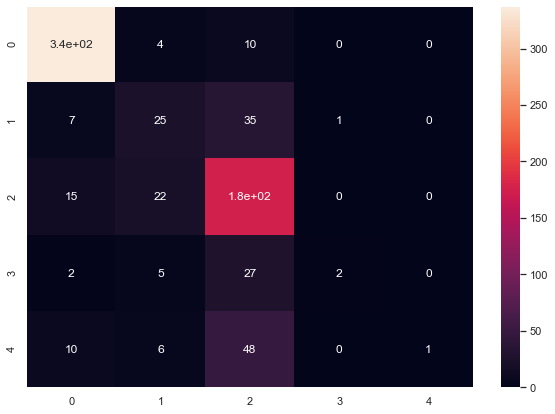

In [135]:
df_cm = pd.DataFrame(cm, range(5), range(5))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)